In [1]:
# %% codecell
import os
import sys
import time
import serial
import math
import numpy as np

# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'utils'))
from Thymio import Thymio
from motion import Robot
from motion import RepeatedTimer

#/dev/cu.usbmodem141101	/dev/cu.usbmodem141401
th = Thymio.serial(port="COM6", refreshing_rate=0.1) #/dev/ttyACM0 for linux
my_th = Robot(th)

time.sleep(3) # To make sure the Thymio has had time to connect

variables = th.variable_description()

print(variables[0])

{'name': '_id', 'offset': 0, 'size': 1}


In [2]:
from ekf import *
#%matplotlib inline
from IPython.display import clear_output

distance:200
target_go_straight:6.334526335793241 s
[[31.415135]
 [-0.063146]]
[[3.17308650e+01]
 [9.97042105e-03]]
[[31.88873]
 [ 0.     ]]
[[ 3.12572700e+01]
 [-1.99408421e-02]]
[[ 3.15730000e+01]
 [-1.32938947e-02]]
[[30.783675  ]
 [-0.03655821]]
actual_go_straight:6.338287353515625 s 

turn_angle:45 

target_turn:1.167072980963743 s
[[ 1.420785  ]
 [-0.65472432]]
actual_turn:1.1743683815002441 s
distance:100
target_go_straight:3.1672631678966203 s
[[29.67862   ]
 [-0.05317558]]
[[3.09415400e+01]
 [2.65877895e-02]]
[[3.20465950e+01]
 [3.32347368e-03]]
actual_go_straight:3.172096014022827 s 

turn_angle:90 

target_turn:2.334145961927486 s
[[12.31347   ]
 [-0.39881684]]
[[-0.31573   ]
 [-0.67798863]]
actual_turn:2.3360328674316406 s
distance:100
target_go_straight:3.1672631678966203 s
[[-0.473595  ]
 [-0.68131211]]
[[ 3.06258100e+01]
 [-2.65877895e-02]]
[[3.22044600e+01]
 [1.32938947e-02]]
[[3.09415400e+01]
 [1.99408421e-02]]
actual_go_straight:3.1755034923553467 s 



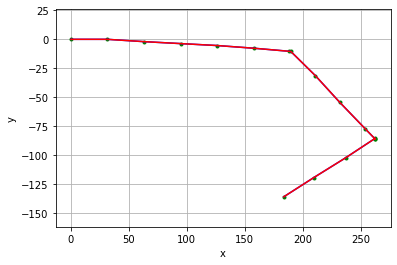

In [6]:
# %% codecell

# State Vector [x y yaw v]'

xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))


def repeated_function():
    global curr_speed, left, right
    global xEst, xTrue, PEst, xDR, hxEst, hxTrue, hxDR, hz

    curr_speed = my_th.get_speed() * 0.31573
    left, right = curr_speed[0], curr_speed[1]
    
    u = calc_input(left, right)

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    plt.cla()
    # for stopping simulation with the esc key.
    plt.gcf().canvas.mpl_connect('key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
    plt.plot(hz[0, :], hz[1, :], ".g")
    plt.plot(hxTrue[0, :].flatten(),
                hxTrue[1, :].flatten(), "-b")
    #plt.plot(hxDR[0, :].flatten(),
    #         hxDR[1, :].flatten(), "-k")
    plt.plot(hxEst[0, :].flatten(),
                hxEst[1, :].flatten(), "-r")
    #plot_covariance_ellipse(xEst, PEst)
    plt.axis('equal')
    plt.grid(True)
    #plt.xlim(0, 0.2)
    #plt.ylim(-0.05,0.05)
    
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.pause(0.001)

rt_speed = RepeatedTimer(1, repeated_function)

my_th.set_speed(100)

my_th.go_straight(200)
my_th.turn(45)
my_th.go_straight(100)
my_th.turn(90)
my_th.go_straight(100)


rt_speed.stop()
my_th.stop()


distance:200
target_go_straight:6.334526335793241 s
0.0
0.009970421052631573
-0.013293894736842171
0.009970421052631628
0.009970421052631573
-0.009970421052631573
actual_go_straight:6.336228609085083 s 

turn_angle:90 

target_turn:2.334145961927486 s
-0.6713416842105264
-0.6281365263157894
actual_turn:2.3394789695739746 s
distance:200
target_go_straight:6.334526335793241 s
-0.16949715789473688
0.019940842105263146
0.006646947368421141
0.0
0.02991126315789472
-0.02658778947368423
actual_go_straight:6.343421220779419 s 

[[ 3.09415400e+01]
 [-2.65877895e-02]]
[[ 3.09415400e+01]
 [-2.65877895e-02]]
1.0
-0.04652863157894738
[[30.62581   ]
 [-0.04652863]]
[[30.62581   ]
 [-0.04652863]]
2.0
[[30.62581   ]
 [-0.04652863]]
[[30.62581   ]
 [-0.04652863]]
3.0
[[30.62581   ]
 [-0.04652863]]
[[30.62581   ]
 [-0.04652863]]
4.0
[[30.62581   ]
 [-0.04652863]]
[[30.62581   ]
 [-0.04652863]]
5.0
[[30.62581   ]
 [-0.04652863]]
[[30.62581   ]
 [-0.04652863]]
6.0
[[30.62581   ]
 [-0.04652863]]
[[30.62581

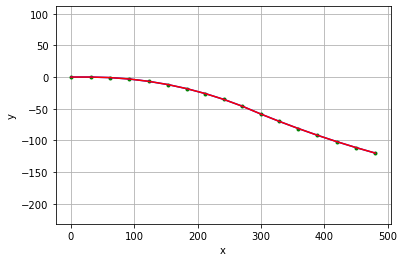

In [3]:
# %% codecell


def repeated_function():
    global curr_speed, left, right
    curr_speed = my_th.get_speed() * 0.31573
    left, right = curr_speed[0], curr_speed[1]
    print(left/95 - right/95)

rt_speed = RepeatedTimer(1, repeated_function)

my_th.set_speed(100)
my_th.go_straight(200)

my_th.turn(90)
my_th.go_straight(200)

time = 0.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

while SIM_TIME >= time:
    time += DT
    u = calc_input(left, right)
    print(u)
    print(time)
    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    if show_animation:
        #clear_output(wait=True)
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(hz[0, :], hz[1, :], ".g")
        plt.plot(hxTrue[0, :].flatten(),
                    hxTrue[1, :].flatten(), "-b")
        #plt.plot(hxDR[0, :].flatten(),
        #         hxDR[1, :].flatten(), "-k")
        plt.plot(hxEst[0, :].flatten(),
                    hxEst[1, :].flatten(), "-r")
        #plot_covariance_ellipse(xEst, PEst)
        plt.axis('equal')
        plt.grid(True)
        #plt.xlim(0, 0.2)
        #plt.ylim(-0.05,0.05)
        
        plt.xlabel('x')
        plt.ylabel('y')
        #plt.pause(0.001)



#my_th.move_to_target([40,40])
#my_th.move_to_target([100,220])


rt_speed.stop()
my_th.stop()


In [5]:
rt_speed.stop()
my_th.stop()

In [9]:
















# %% codecell
my_th.rt_speed.start()
test = my_th.speed_array[-1]
#print(test)
my_th.set_speed(100)
#test = my_th.get_speed()
#print(test)
#print(len(test))
#my_th.forward(300)
#my_th.turn(360)
#my_th.go_straight(500)
my_th.turn(360)
#my_th.turn(-180)

# %% codecell
my_th.rt_speed.stop()
my_th.stop()

turn_angle:360 

target_turn:9.336583847709944 s
actual_turn:9.338542699813843 s


In [5]:
print(test)

None


In [10]:
my_th.rt_speed.start()

my_th.move_to_target([100,0])
my_th.move_to_target([100,50])
my_th.set_position([0,0,0])

my_th.rt_speed.stop()
my_th.stop()

turn_angle:0.0 

target_turn:0.0 s
distance:100.0
target_go_straight:3.1672631678966203 s
[103  99]
[ 99 100]
[102  99]
actual_go_straight:3.1724181175231934 s 

turn_angle:90.0 

target_turn:2.334145961927486 s
[-92  96]
[-96 102]
actual_turn:2.3398423194885254 s
distance:50.0
target_go_straight:1.5836315839483102 s
[ 83 100]
[94 98]
actual_go_straight:1.5901963710784912 s 



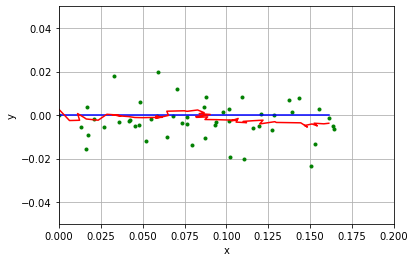

In [9]:
from ekf import *
%matplotlib inline
from IPython.display import clear_output

def main():
    #print(__file__ + " start!!")
    print("start!")

    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        if show_animation:
            clear_output(wait=True)
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(hz[0, :], hz[1, :], ".g")
            plt.plot(hxTrue[0, :].flatten(),
                     hxTrue[1, :].flatten(), "-b")
            #plt.plot(hxDR[0, :].flatten(),
            #         hxDR[1, :].flatten(), "-k")
            plt.plot(hxEst[0, :].flatten(),
                     hxEst[1, :].flatten(), "-r")
            #plot_covariance_ellipse(xEst, PEst)
            #plt.axis("equal")
            plt.grid(True)
            plt.xlim(0, 0.2)
            plt.ylim(-0.05,0.05)
            
            plt.xlabel('x')
            plt.ylabel('y')
            plt.pause(0.001)

if __name__ == '__main__':
    main()

In [5]:
# %% codecell

my_th.go_straight(500)

"""
my_th.forward(100)
my_th.turn(180)
my_th.turn(360)
my_th.turn(-720)
my_th.move_to_target([0,1])
my_th.move_to_target([12,33])

full_path = np.array([[0,1,1,2,3,4,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,38,39,39,39,40]])

full_path = full_path.T

for i in range(len(full_path)):
    my_th.move_to_target([full_path[i,0],full_path[i,1]])
    pos_th = my_th.get_position()
    print("Thymio position: {}".format(pos_th))"""
conversion = 0.31573
speed = 31.573 #[mm/s]

print(my_th.get_speed())
my_th.stop()


distance:5000
target_time_forward:158.36315839483103
actual_time_forward:158.36512279510498 

[101, 102]


In [6]:
my_th.stop()
